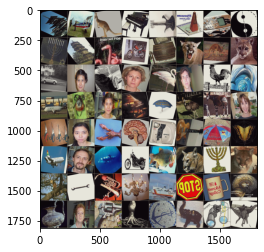

In [5]:
'''
We write this code with the help of PyTorch demo:
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    
Dataset is Downloaded from https://www.kaggle.com/huangruichu/caltech101/version/2

Effects:
        transforms.Resize((230,230)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),

wide_resnet101_2 SpinalNet_VGG gives 96.87% test accuracy

wide_resnet101_2 SpinalNet_ResNet gives 96.40% test accuracy
'''

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy




plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((230,230)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

data_dir = '../input/caltech101/Caltech101/Caltech101'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'eval', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'eval', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

In [6]:
#%%

# model_ft = models.vgg19_bn(pretrained=True)
# num_ftrs = model_ft.classifier[0].in_features

model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features

half_in_size = round(num_ftrs/2)
layer_width = 101 #Small for Resnet, large for VGG
Num_class=101

class SpinalNet_ResNet(nn.Module):
    def __init__(self):
        super(SpinalNet_ResNet, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)
        
    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x
    
class SpinalNet_VGG(nn.Module):
    def __init__(self):
        super(SpinalNet_VGG, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x



VGG_fc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, Num_class)
        )


'''
Changing the fully connected layer to SpinalNet or VGG or ResNet
'''

#model_ft.fc = nn.Linear(num_ftrs, 101)
model_ft.fc = SpinalNet_ResNet()#SpinalNet_ResNet() #SpinalNet_VGG()

In [7]:
print(model_ft)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))



        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [8]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 3.0938 Acc: 0.3502
eval Loss: 1.6757 Acc: 0.6512
Training complete in 2m 20s
test Loss: 1.7154 Acc: 0.6413

Epoch 1/4
----------
train Loss: 0.9759 Acc: 0.7967
eval Loss: 0.3802 Acc: 0.9061
Training complete in 4m 47s
test Loss: 0.4044 Acc: 0.8991

Epoch 2/4
----------
train Loss: 0.2186 Acc: 0.9518
eval Loss: 0.2313 Acc: 0.9488
Training complete in 7m 11s
test Loss: 0.2183 Acc: 0.9404

Epoch 3/4
----------
train Loss: 0.1010 Acc: 0.9768
eval Loss: 0.2117 Acc: 0.9476

Epoch 4/4
----------
train Loss: 0.0640 Acc: 0.9856
eval Loss: 0.1461 Acc: 0.9598
Training complete in 11m 44s
test Loss: 0.1721 Acc: 0.9569

Training complete in 11m 60s
Best eval Acc: 0.959756


In [9]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0346 Acc: 0.9943
eval Loss: 0.1123 Acc: 0.9720
Training complete in 2m 9s
test Loss: 0.1351 Acc: 0.9652

Epoch 1/4
----------
train Loss: 0.0226 Acc: 0.9963
eval Loss: 0.1172 Acc: 0.9720

Epoch 2/4
----------
train Loss: 0.0189 Acc: 0.9968
eval Loss: 0.1101 Acc: 0.9732
Training complete in 6m 44s
test Loss: 0.1255 Acc: 0.9676

Epoch 3/4
----------
train Loss: 0.0179 Acc: 0.9971
eval Loss: 0.1134 Acc: 0.9732

Epoch 4/4
----------
train Loss: 0.0166 Acc: 0.9981
eval Loss: 0.1129 Acc: 0.9732

Training complete in 11m 20s
Best eval Acc: 0.973171
